In [86]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager,rc
import time
import pandas as pd
import cx_Oracle
import datetime as dt
from datetime import timedelta,datetime
from IPython import display
import math

font_location = "C:\Windows\Fonts\malgun.ttf"
font_name = font_manager.FontProperties(fname=font_location).get_name()
rc('font',family=font_name)
plt.rcParams['axes.unicode_minus'] = False

In [87]:
con = cx_Oracle.connect('bike/12345@192.168.0.78:1521/xe')
cur = con.cursor()

### 일주일치 날짜 가져오기

In [88]:
def week_col(time):
    start=time-timedelta(days=int(time.weekday()))
    week=pd.date_range(start,periods=7)
    return week.astype(str).to_list()

In [89]:
a = cur.execute("""select max(riding_dt) from riding """).fetchall()[0][0]

In [90]:
week_col(a)

['2023-02-06',
 '2023-02-07',
 '2023-02-08',
 '2023-02-09',
 '2023-02-10',
 '2023-02-11',
 '2023-02-12']

## 주간 데이터

### 내 데이터

#### 주행거리분석

In [91]:
cur.execute("""select id, distance, riding_dt from riding """)

columns = ['id','distance','date_time']
distance_data = pd.DataFrame(cur,columns = columns)

In [138]:
def plt_dis_update(id):

    cur.execute("select * from riding where id = :id order by riding_dt",id)
    
    time=week_col(pd.to_datetime(a))
    
    columns = ['id','distance','calorie','riding_time','riding_dt']
    riding_data = pd.DataFrame(cur,columns=columns)
    riding_data['riding_dt']=riding_data['riding_dt'].astype(str)
    riding_data= riding_data[riding_data['riding_dt'].isin(time)]
    
    df2=pd.DataFrame(time,columns=['riding_dt'])
    
    
    b=pd.merge(riding_data,df2,on='riding_dt', how='outer')
    b.fillna(0,inplace=True)
    
#     ax.plot(b['riding_dt'],b['distance'], 'ro--')
#     hdisplay.update(fig)
    return b[['riding_dt','distance']]

In [139]:
plt_dis_update('1')

,riding_dt,distance
0,2023-02-06,20.0
1,2023-02-07,20.0
2,2023-02-08,0.0
3,2023-02-09,0.0
4,2023-02-10,0.0
5,2023-02-11,0.0
6,2023-02-12,0.0


### 평균 데이터

#### 주행거리 분석

In [140]:
def plt_dis_avg_update():
    # 일별로 km 총 평균
    cur.execute("""select riding_dt,sum(distance),round(sum(distance)/(select count(distinct(id)) from riding),2) as avg 
                from riding group by riding_dt order by riding_dt
                    """)
    time=week_col(pd.to_datetime(a))
    
    columns = ['riding_dt','sum','avg_dis']
    dis_avg_data = pd.DataFrame(cur,columns = columns)
    dis_avg_data['riding_dt']=dis_avg_data['riding_dt'].astype(str)
    dis_avg_data= dis_avg_data[dis_avg_data['riding_dt'].isin(time)]
    
    df2=pd.DataFrame(time,columns=['riding_dt'])
    b=pd.merge(dis_avg_data,df2,on='riding_dt', how='outer')
    b.fillna(0,inplace=True)
   
#     ax.plot(time,b['avg_dis'], 'yo-')
  
#     hdisplay.update(fig)
    return b[['riding_dt','avg_dis']]

In [141]:
plt_dis_avg_update()

,riding_dt,avg_dis
0,2023-02-06,24.67
1,2023-02-07,28.00
2,2023-02-08,6.67
3,2023-02-09,0.00
4,2023-02-10,0.00
5,2023-02-11,0.00
6,2023-02-12,0.00


### 상위 10%

#### 주행거리 분석

In [144]:
def plt_dis_avg_update_10():

    cur.execute("""select riding_dt,round(sum(distance)/(select ceil(count(distinct(id))*0.1) from riding),2) as avg from riding where id in (select id from 
    (select sum(distance) sum, id from riding where riding_dt 
    between :start_day and :end_day group by id order by sum desc) 
    where rownum<= (select ceil(count(distinct(id))*0.1) from riding)) group by riding_dt order by riding_dt""",(week_col(a)[0],week_col(a)[6]))
    
    time=week_col(pd.to_datetime(a))

    columns = ['date','avg']
    data = pd.DataFrame(cur,columns = columns)
    
    data['date']=data['date'].astype(str)
    data= data[data['date'].isin(time)]
    
    df2=pd.DataFrame(time,columns=['date'])
    b=pd.merge(data,df2,on='date', how='outer')
    b.fillna(0,inplace=True)
    
#     ax.plot(time,b['avg'], 'b*-')
    
#     hdisplay.update(fig)
    return b[['date','avg']]

In [147]:
plt_dis_avg_update_10()['date']

0    2023-02-06
1    2023-02-07
2    2023-02-08
3    2023-02-09
4    2023-02-10
5    2023-02-11
6    2023-02-12
Name: date, dtype: object

### 실시간그래프

##### yellow => 평균데이터 red => 나의데이터 blue => 상위10% 데이터

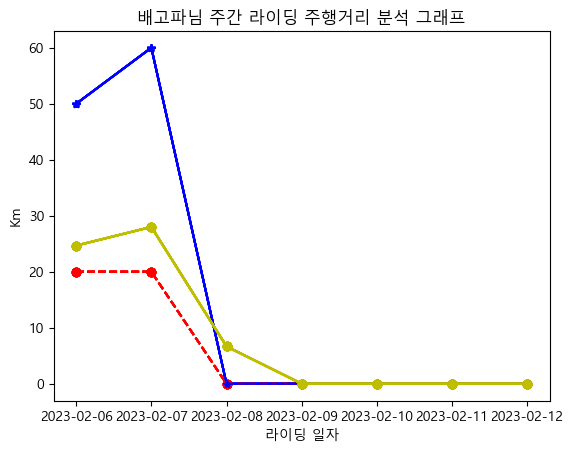

KeyboardInterrupt: 

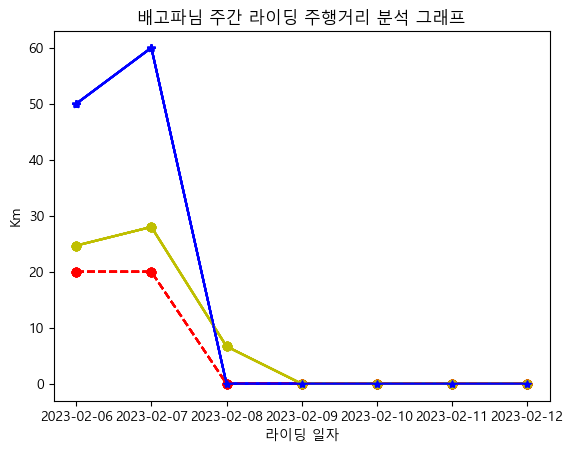

In [117]:
#목표치 설정하기
import matplotlib.pyplot as plt
from matplotlib import dates

fig,ax = plt.subplots(1,1)
hdisplay = display.display("", display_id=True)

plt.title(' 배고파님 주간 라이딩 주행거리 분석 그래프 ')
# plt.rcParams['figure.figsize'] = (13,3)

ax.set_xlabel('라이딩 일자')
ax.set_ylabel('Km')

# plt_update(ax)
for f in range(1000000000):
    plt_dis_update(ax,'1')
    plt_dis_avg_update(ax)
    plt_dis_avg_update_10(ax)
    plt.savefig('distance_chart.png')
    time.sleep(1)

plt.close()

In [179]:
import matplotlib.pyplot as plt
from matplotlib import dates

def fx():
    my_data=plt_dis_update('1')
    avg_data=plt_dis_avg_update()
    vip_data=plt_dis_avg_update_10()
#     fig,ax = plt.subplots(1,1)
#     hdisplay = display.display("", display_id=True)
    
#     plt.title(' 배고파님 주간 라이딩 주행거리 분석 그래프 ')
    # plt.rcParams['figure.figsize'] = (13,3)

#     ax.set_xlabel('라이딩 일자')
#     ax.set_ylabel('Km')
    #---------그림사이즈, 바 굵기 조정
    fig, ax = plt.subplots(figsize=(12,6))
    bar_width = 0.15
    #----------인덱스
    index=np.array(range(7))
    # ----------각 3개 bar를 순서대로 나타내는 과정, 각 그래프는 0.25의 간격을 두고 그려짐
    my_chart = plt.bar(index-bar_width, my_data['distance'], width=bar_width,  color='red', label='나의 기록')
    avg_chart = plt.bar(index, avg_data['avg_dis'], width=bar_width,  color='blue', label='평균')
    vip_chart = plt.bar(index+bar_width, vip_data['avg'], width=bar_width,  color='green', label='상위10%')
    
    #x축 표시
    plt.xticks(range(7),vip_data['date'])

    plt.xlabel('라이딩 일자')
    plt.ylabel('Km')
    plt.legend()
#     plt.show()
    plt.savefig('distance_chart.png')
# plt_update(ax)


KeyboardInterrupt: 

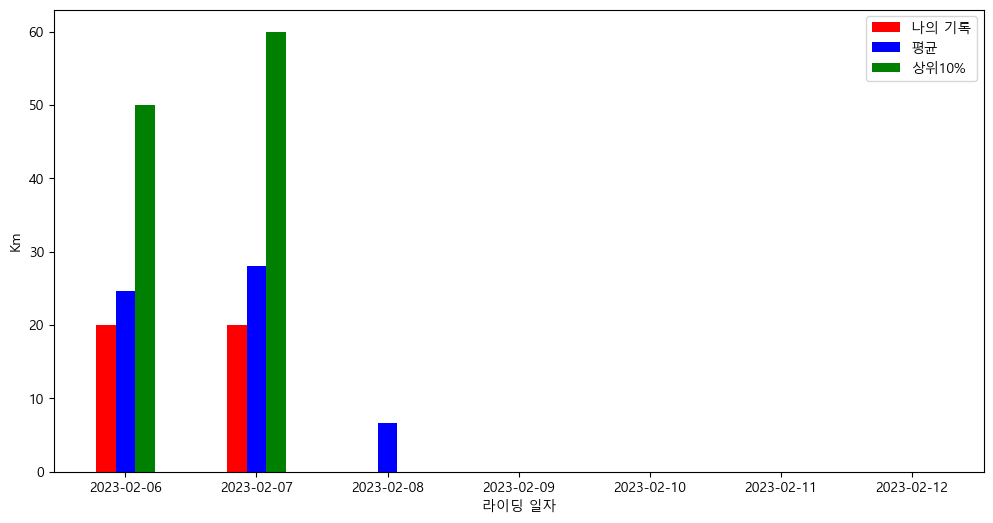

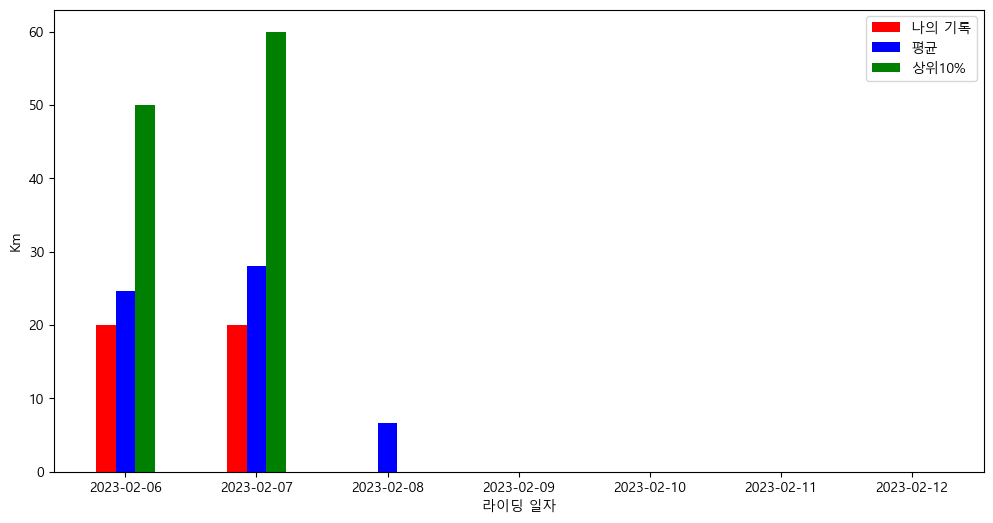

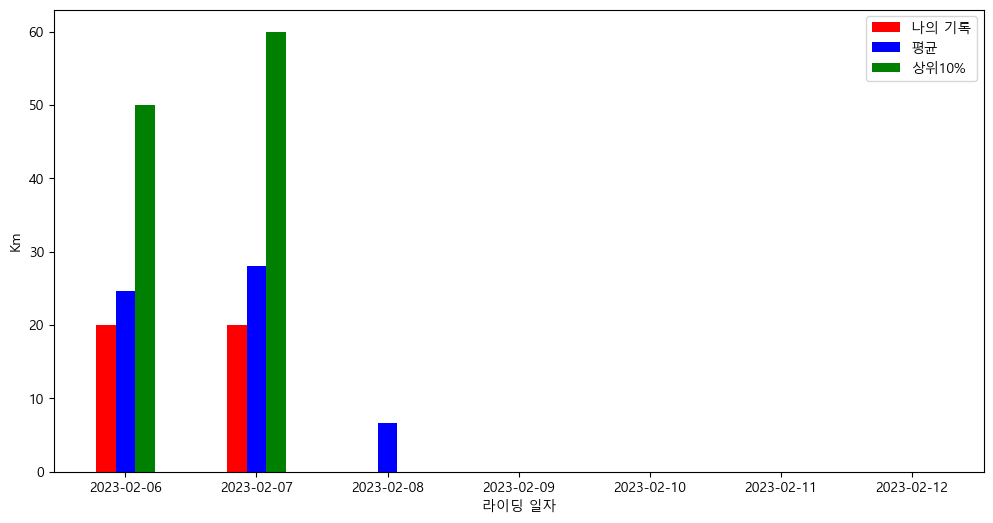

In [180]:
for f in range(1000000000):
    fx()
    time.sleep(5)

plt.close()